In [1]:
from mne_bids import make_bids_basename
from pathlib import Path, PurePath
import mne
import os
import matplotlib.pyplot as plt
import pandas as pd
import matlab.engine
import numpy as np
import scipy as sp
import scipy.io
pd.options.display.html.table_schema = True
pd.options.display.max_rows = None
from mne.time_frequency import psd_multitaper

In [2]:
%matplotlib 
#plt.rcParams.update({'font.size': 16})

Using matplotlib backend: Qt5Agg


In [3]:
# Load data
subpath = Path('~','projects','CIFAR','data_bids', 'sub-05' ).expanduser()
bids_basename = make_bids_basename(subject='05',
                                   task='rest', run='01', suffix='ieeg.vhdr')
fname = subpath.joinpath('ieeg', bids_basename)

In [4]:
raw = mne.io.read_raw_brainvision(fname, preload=True)

Extracting parameters from /home/guime/projects/CIFAR/data_bids/sub-05/ieeg/sub-05_task-rest_run-01_ieeg.vhdr...
Setting channel info structure...
Reading 0 ... 104998  =      0.000 ...   209.996 secs...


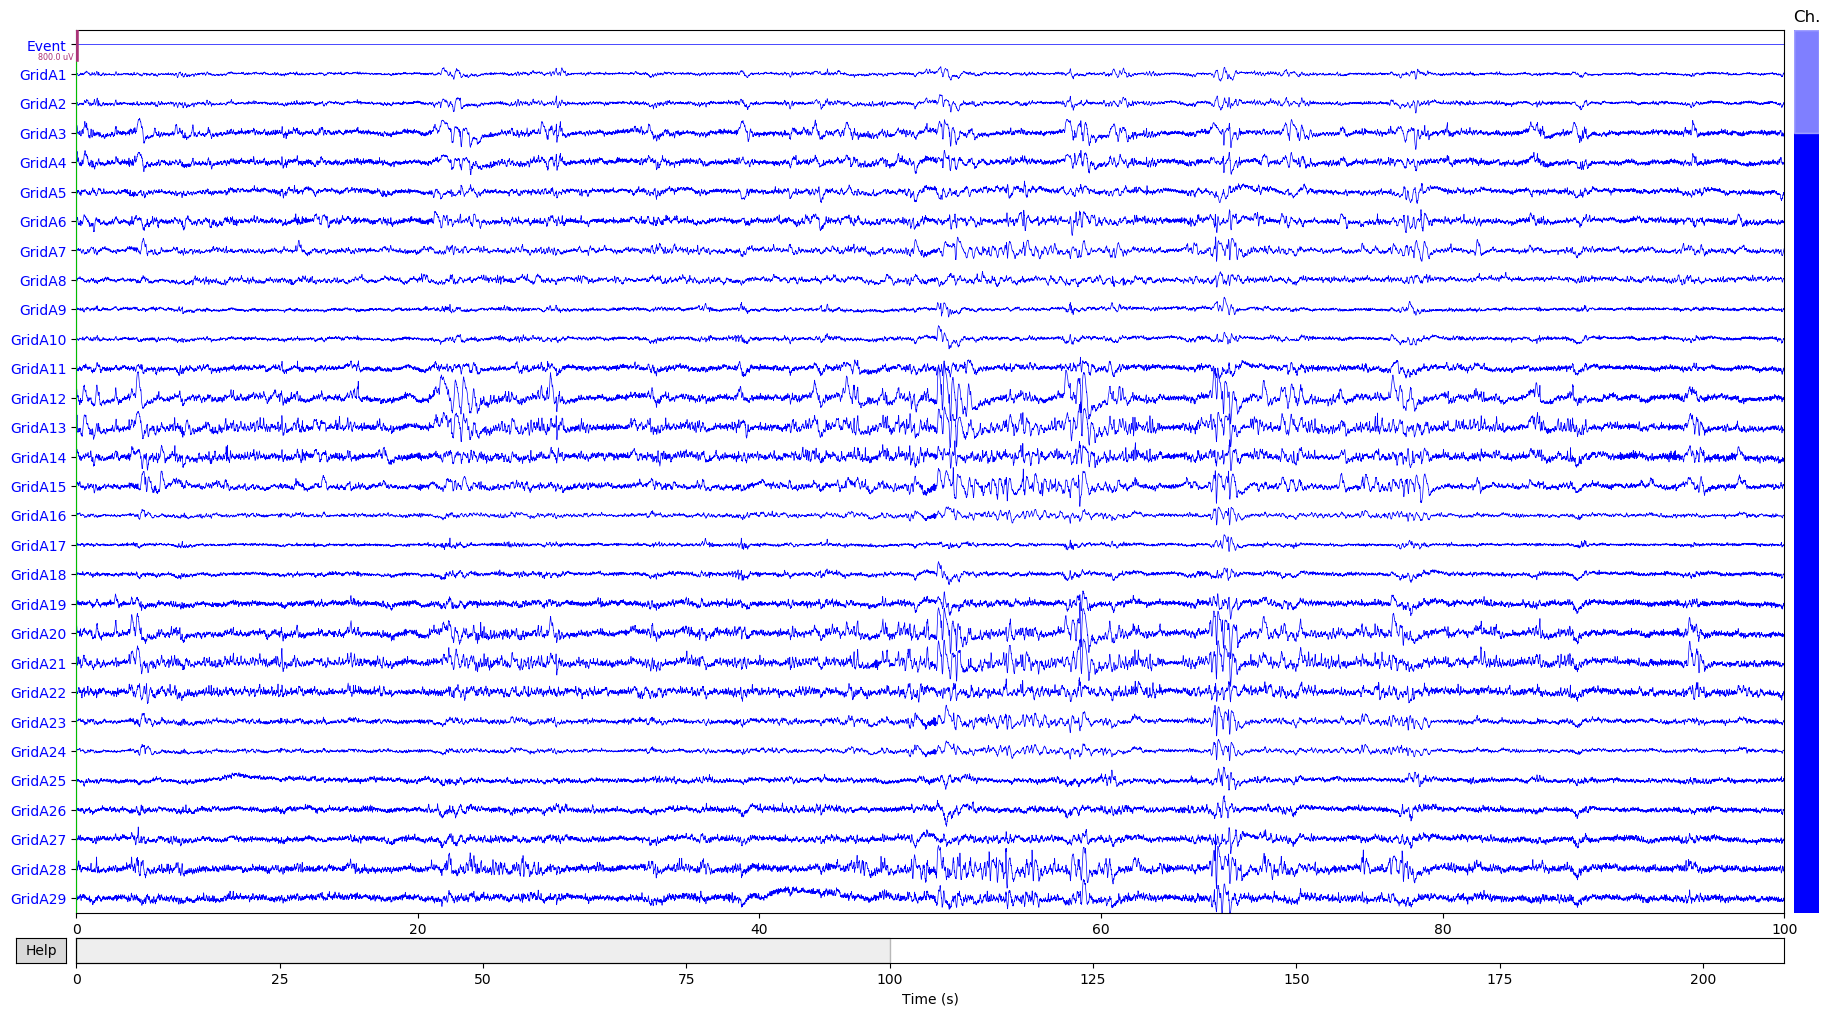

In [14]:
# Plot raw data

raw.plot(duration=100, n_channels=30, scalings=4e-4, color='b')


In [5]:
# Drop bad channels
raw.set_channel_types({'ECG': 'ecg'})
bads = ['TRIG', 'ECG', 'P3', 'T5', 'T3', 'F3', 'F7'] # This is specific to subject 00
raw.info['bads'] = bads
raw_bad = raw.copy().pick_types(eeg=True, ecog=True, exclude = 'bads')

In [6]:
# Keep track of picked channels 
ch_names = raw_bad.info['ch_names']

In [38]:
# Save resulting data in mat file 
# data = raw_bad.get_data()
# dsub_path = Path('~','projects','CIFAR','data_bids', 'derivatives','sub-00').expanduser()
# mat_bids_basename = make_bids_basename(subject='00',
#                                    task='rest', run='01', processing='bads', suffix='ieeg.mat')
# datapath = dsub_path.joinpath(mat_bids_basename)
# datapath = os.fspath(datamat)

# scipy.io.savemat(datapath, dict(data=data))

/home/guime/projects/CIFAR/data_bids/derivatives/sub-00/sub-00_task-rest_run-01_proc-bads_ieeg.mat


In [7]:
# load line noise removed data
dsub_path = Path('~','projects','CIFAR','data_bids', 'derivatives','sub-00').expanduser()
mat_bids_basename = make_bids_basename(subject='00',
                                   task='rest', run='01', processing='lnrmv', suffix='ieeg.mat')
datapath = dsub_path.joinpath(mat_bids_basename)
data = scipy.io.loadmat(datapath)
ts = data['data_lnrmv']

In [8]:
# Update data  
raw_lnrmv = mne.io.RawArray(ts, raw_bad.info)

Creating RawArray with float64 data, n_channels=121, n_times=104999
    Range : 0 ... 104998 =      0.000 ...   209.891 secs
Ready.


Effective window size : 4.094 (s)


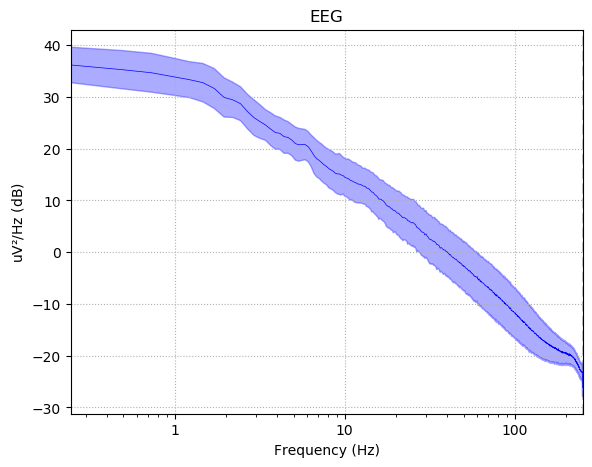

In [10]:
# Plot preproc cpsd
raw_lnrmv.plot_psd(color = 'blue', average = 'true', xscale='log', show = False)

In [46]:
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
# raw
psds_raw, freqs = psd_multitaper(raw, low_bias=True)
psds_raw = 10 * np.log10(psds_raw)
psds_raw_mean = psds_raw.mean(0)
psds_raw_std = psds_raw.std(0)

# lnrmv

psds_lnrmv, freqs = psd_multitaper(raw_lnrmv, low_bias=True)
psds_lnrmv = 10 * np.log10(psds_lnrmv)
psds_lnrmv_mean = psds_lnrmv.mean(0)
psds_lnrmv_std = psds_lnrmv.std(0)


ax1.plot(freqs, psds_raw_mean, color='b')
ax1.fill_between(freqs, psds_raw_mean - psds_raw_std, psds_raw_mean + psds_raw_std,
                color='b', alpha=.5)
ax1.set(title='Multitaper PSD raw data subject 0, resting state, n=121', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
ax1.set_xscale('log')


ax2.plot(freqs, psds_lnrmv_mean, color='b')
ax2.fill_between(freqs, psds_lnrmv_mean - psds_lnrmv_std, psds_lnrmv_mean + psds_lnrmv_std,
                color='b', alpha=.5,)
ax2.set(title='Multitaper PSD, line noise removed, subject 0, resting state, n=121', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
ax2.set_xscale('log')


plt.show()


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [9]:
# Load Robust rerefencing
mat_bids_basename = make_bids_basename(subject='00',
                                   task='rest', run='01', processing='ref', suffix='ieeg.mat')
datapath = dsub_path.joinpath(mat_bids_basename)
data = scipy.io.loadmat(datapath)
ts = data['data_ref']
print(ts)

[[-2.15020831e-04 -2.15848323e-04 -2.24486263e-04 ... -1.08636597e-04
  -9.99255237e-05 -9.16218243e-05]
 [-3.46074910e-04 -3.44737736e-04 -3.47386135e-04 ...  1.44894161e-04
   1.40375929e-04  1.35275480e-04]
 [-2.68459935e-04 -2.72689860e-04 -2.79027139e-04 ...  1.28944950e-04
   1.22842868e-04  1.18024724e-04]
 ...
 [ 7.27019910e-05  7.21291144e-05  7.55612227e-05 ...  2.87069083e-05
   2.89446259e-05  2.83252389e-05]
 [ 8.59460550e-05  8.36816698e-05  9.09714121e-05 ...  3.51190448e-05
   2.80187340e-05  1.95413934e-05]
 [ 4.12913149e-05  2.89875806e-05  1.05333108e-05 ...  4.23413545e-05
   4.11599198e-05  3.62160924e-05]]


In [10]:
# Make ref data
raw_ref = mne.io.RawArray(ts, raw_bad.info)

Creating RawArray with float64 data, n_channels=121, n_times=104999
    Range : 0 ... 104998 =      0.000 ...   209.891 secs
Ready.


In [ ]:
# Plot ref data

raw_ref.plot(duration=200, n_channels=60, scalings=4e-4, color='b')

In [11]:
# Load detrended data
mat_bids_basename = make_bids_basename(subject='00',
                                   task='rest', run='01', processing='detrend', suffix='ieeg.mat')
datapath = dsub_path.joinpath(mat_bids_basename)
data = scipy.io.loadmat(datapath)
ts = data['data_detrend']
print(ts)

[[-2.34817246e-04 -2.35627192e-04 -2.44247433e-04 ... -1.19071194e-04
  -1.10312084e-04  0.00000000e+00]
 [-3.36338075e-04 -3.34908506e-04 -3.37464325e-04 ...  8.83147411e-05
   8.39539468e-05  0.00000000e+00]
 [-2.26760268e-04 -2.30822180e-04 -2.36991382e-04 ...  6.80583547e-05
   6.20127504e-05  0.00000000e+00]
 ...
 [ 5.85787891e-05  5.79141421e-05  6.12544769e-05 ... -8.08423872e-06
  -7.86043973e-06  0.00000000e+00]
 [ 6.68412391e-05  6.45701166e-05  7.18531292e-05 ...  4.34377629e-05
   3.63132317e-05  0.00000000e+00]
 [-1.02845417e-05 -2.24784429e-05 -4.08228980e-05 ...  2.08601977e-05
   1.96893347e-05  0.00000000e+00]]


In [12]:
# Make detrended data
raw_detrend = mne.io.RawArray(ts, raw_lnrmv.info)

Creating RawArray with float64 data, n_channels=121, n_times=104999
    Range : 0 ... 104998 =      0.000 ...   209.891 secs
Ready.


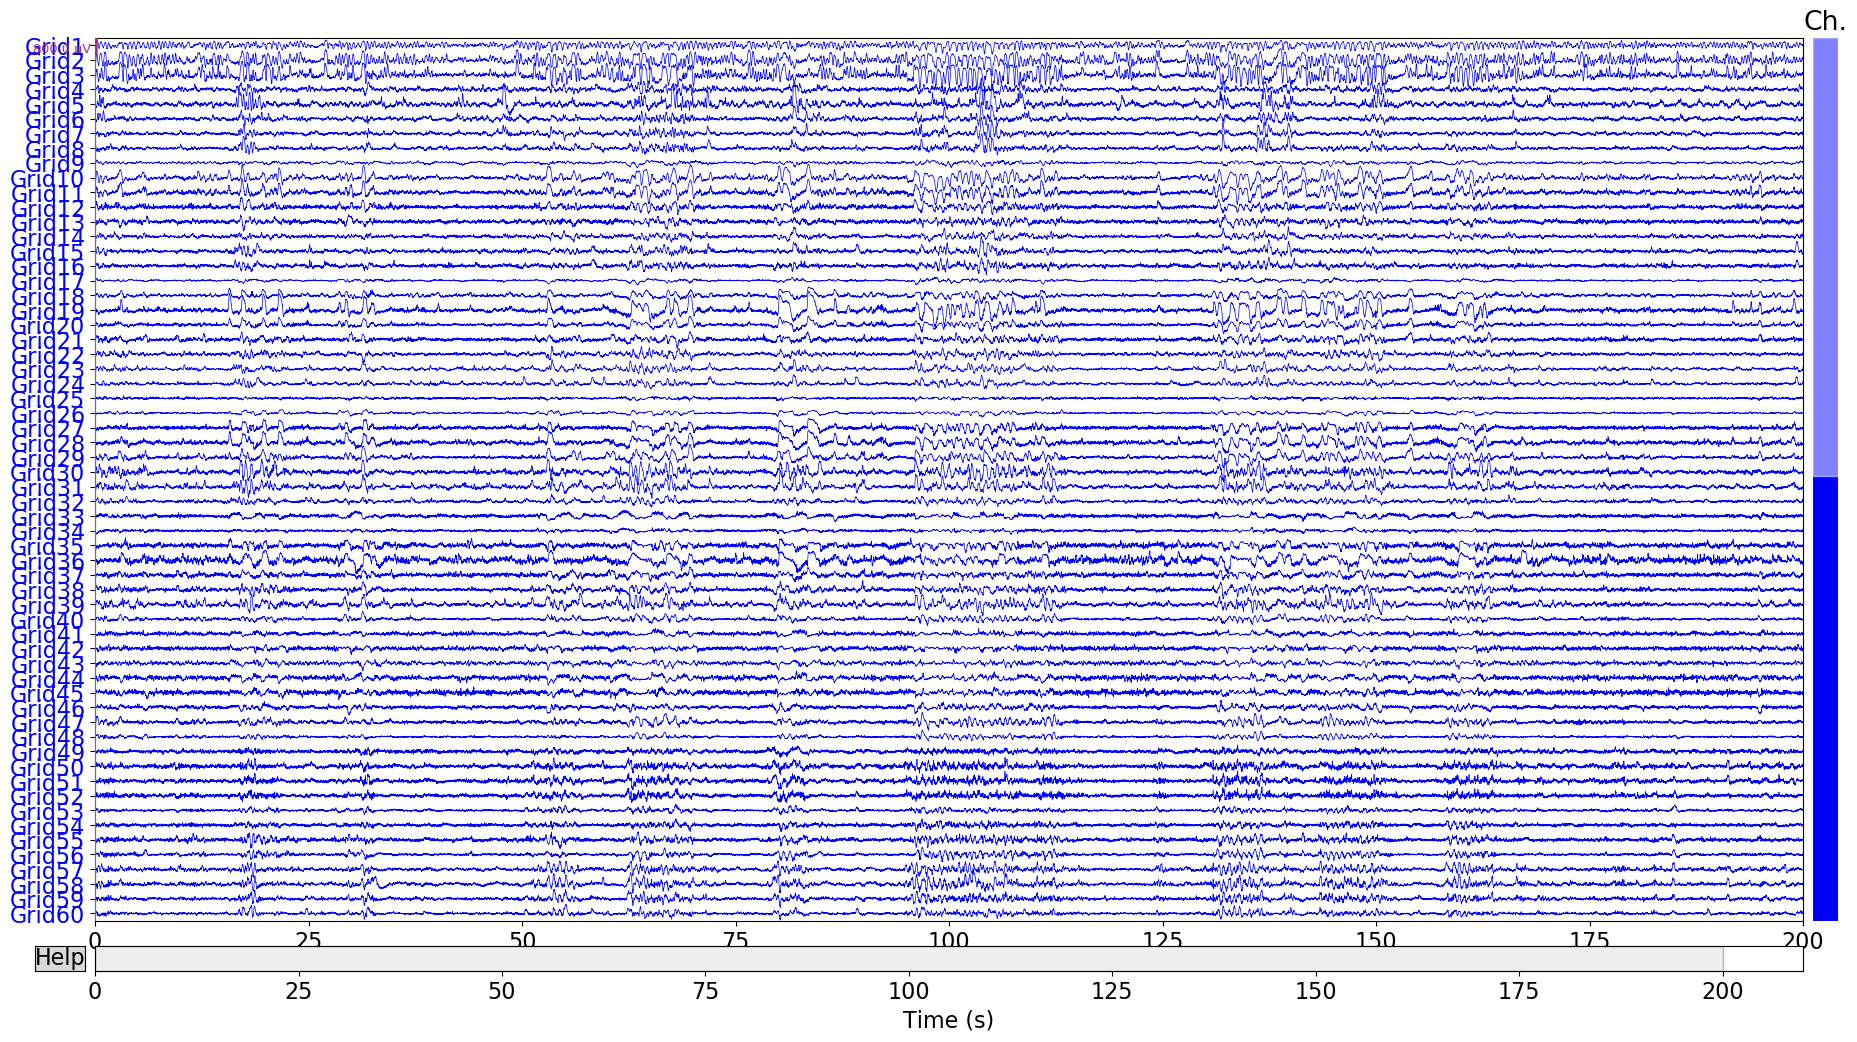

In [13]:
# Plot detrend data

raw_detrend.plot(duration=200, n_channels=60, scalings=4e-4, color='b')


In [14]:
# Load outlier removed data 
mat_bids_basename = make_bids_basename(subject='00',
                                   task='rest', run='01', processing='outlrmv', suffix='ieeg.mat')
datapath = dsub_path.joinpath(mat_bids_basename)
data = scipy.io.loadmat(datapath)
ts = data['data_outlrmv']
print(ts)

[[-1.51810345e-04 -1.51738387e-04 -1.53989707e-04 ...  4.22862187e-05
   4.19620049e-05 -6.40960364e-07]
 [-3.14742063e-04 -3.16062848e-04 -3.23134216e-04 ... -3.83840593e-05
  -3.54447462e-05  7.38895081e-07]
 [-3.26710675e-04 -3.33691642e-04 -3.34398644e-04 ...  1.17027833e-05
   8.54506537e-06 -4.21443843e-06]
 ...
 [ 7.01574696e-05  6.94835063e-05  7.14802160e-05 ... -4.90206905e-06
  -3.83611049e-06 -1.39528183e-06]
 [ 6.10204552e-05  5.83677311e-05  5.99632126e-05 ...  1.22739154e-05
   1.42536427e-05  4.72662035e-07]
 [ 1.07712507e-04  1.07128282e-04  1.08073813e-04 ... -4.62941666e-05
  -4.71488477e-05  8.90127499e-07]]


In [15]:
# Make outlier removed data
raw_outlrmv = mne.io.RawArray(ts, raw_detrend.info)

Creating RawArray with float64 data, n_channels=121, n_times=104999
    Range : 0 ... 104998 =      0.000 ...   209.891 secs
Ready.


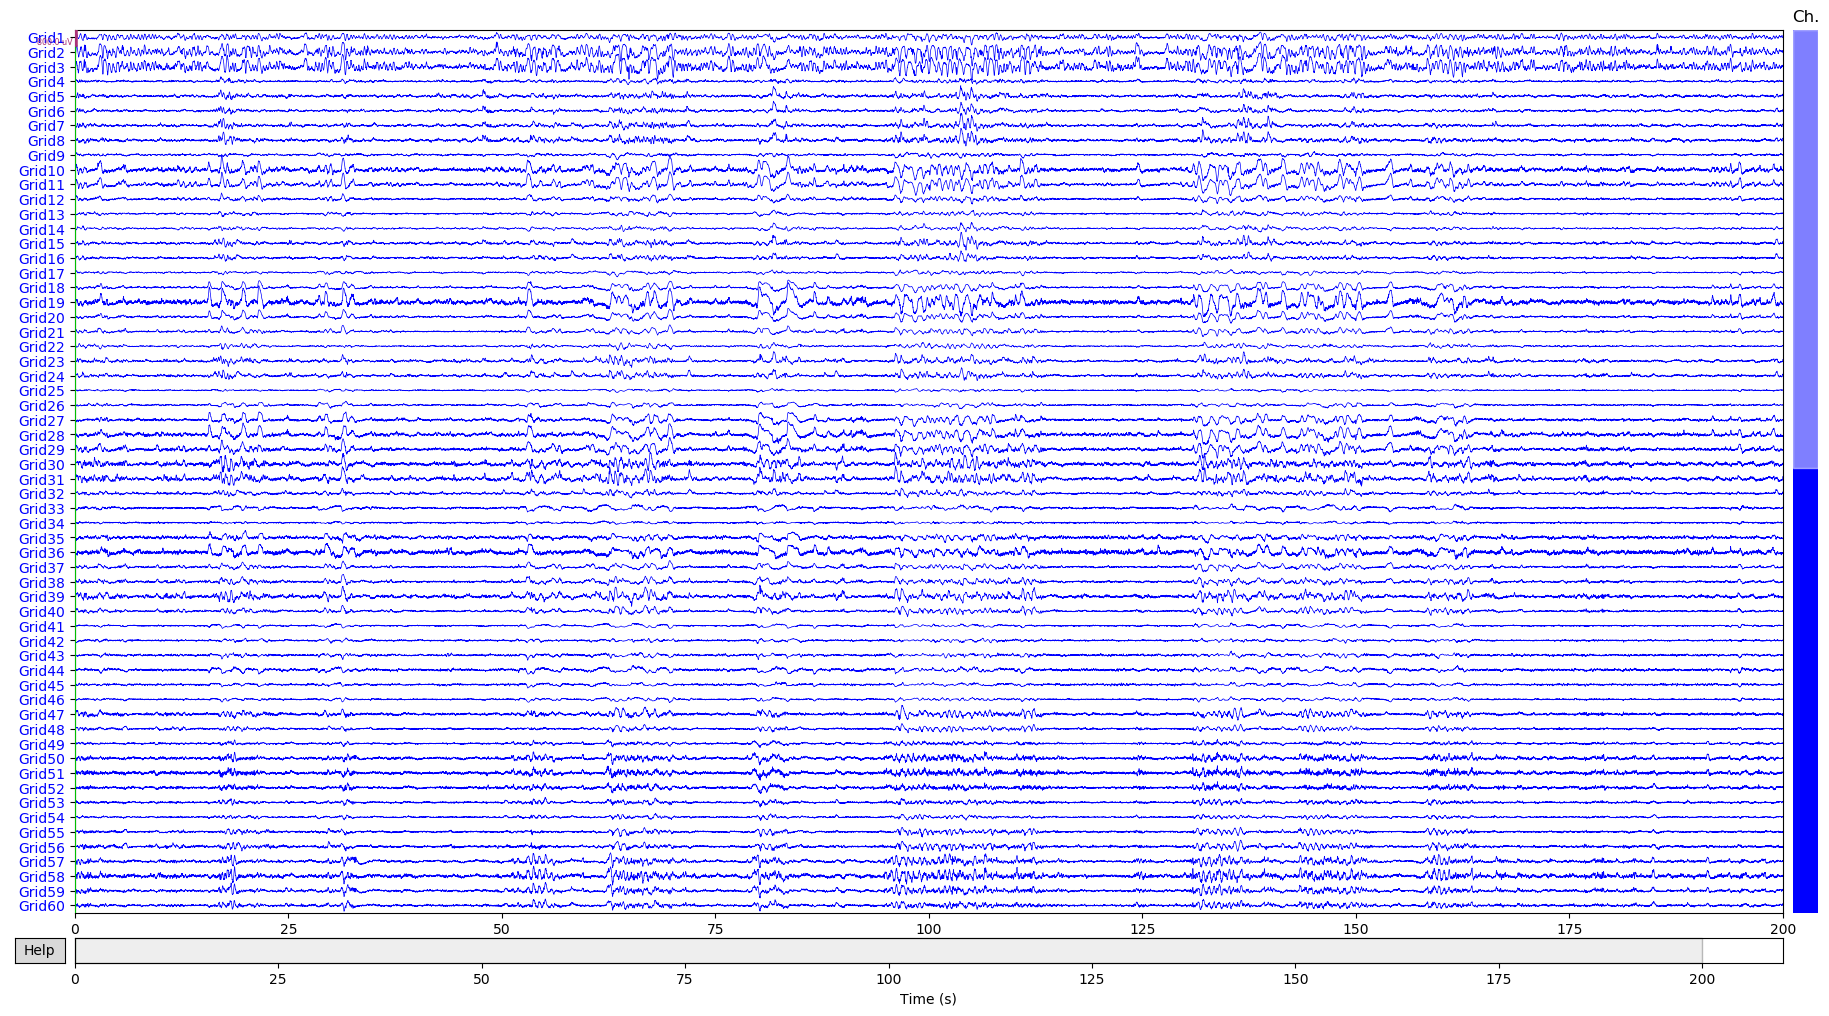

In [16]:
# Plot outlier removed data

raw_outlrmv.plot(duration=200, n_channels=60, scalings=4e-4, color='b')

In [16]:
elecinfo = subpath.joinpath('anat','electrodes_info.csv')
dfelec = pd.read_csv(elecinfo)
ROIs = dfelec['Brodman'].unique()
nROIs = len(ROIs)

In [17]:
# Select electrodes in specific ROIs
# ToDo will need to change order 
MT = dfelec['electrode_name'].loc[dfelec['Brodman'] == 'MT']
V1 = dfelec['electrode_name'].loc[dfelec['Brodman'] == 'V1']
V2 = dfelec['electrode_name'].loc[dfelec['Brodman'] == 'V2']
MT_chan = MT.array.to_numpy()
V2_chan = V2.array.to_numpy()
V1_chan = V1.array.to_numpy()
MT_list = MT_chan.tolist()
V1_list = V1_chan.tolist()
V2_list = V2_chan.tolist()
ROIs = [*MT_list, *V1_list, *V2_list]

In [18]:
# make preprocess data 
raw_preproc = raw_outlrmv.copy()

In [20]:
# Unknown ROIs will be ignore
data_ROI = raw_preproc.get_data(picks=ROIs)

In [21]:
# Save data 
mat_bids_basename = make_bids_basename(subject='00',
                                   task='rest', run='01', processing='ROIs', suffix='ieeg.mat')
datapath = dsub_path.joinpath(mat_bids_basename)
datapath = os.fspath(datapath)

scipy.io.savemat(datapath, dict(data=data_ROI, MT=MT_list, V1=V1_list, V2=V2_list))

In [75]:
# Superimpose detrend to show 
chan_raw = raw['Grid58'][0]
time_chan_raw =  raw['Grid58'][1]
chan_detrend = raw_detrend['Grid58'][0]
time_chan_detrend =  raw_detrend['Grid58'][1]
chan_raw = chan_raw[0].tolist()
chan_detrend = chan_raw_detrend[0].tolist()
#time_chan_raw.tolist()

In [68]:
time_range = slice(5000, 15000, 1)
#time_range = [*time_range]

In [84]:
plt.plot(time_chan_raw[time_range], chan_raw[time_range], label = 'raw')
plt.plot(time_chan_detrend[time_range], chan_raw_detrend[time_range], label = 'detrended' )
plt.axhline(y=0, color='k')
plt.xlabel('Time (sec)')
plt.ylabel('Potential (V)')
plt.title("Robust detrending of raw data, resting state, subject 0")
plt.legend()

In [87]:
chan_outlrmv = raw['Grid36'][0]
chan_raw = raw['Grid36'][0]
chan_raw = chan_raw[0].tolist()
chan_outlrmv = chan_outlrmv[0].tolist()

In [88]:
plt.plot(time_chan_raw[time_range], chan_raw[time_range], label = 'raw')
plt.plot(time_chan_detrend[time_range], chan_outlrmv[time_range], label = 'oulrmv' )
plt.axhline(y=0, color='k')
plt.xlabel('Time (sec)')
plt.ylabel('Potential (V)')
plt.title("Robust detrending of raw data, resting state, subject 0")
plt.legend()